In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image

import time
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp
import pandas as pd
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

from scipy import stats
from scipy.stats import mannwhitneyu

In [2]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

### Load data from MC approximation of permutation test

In [3]:
def loadMcResult(sampleShape, mean):
    X_list = list()
    y_list = list()
    p_val_list = list()
    time_listMc = list()
    for S in sampleShape:
        X = pd.read_csv("dataFastPerm/data_{}/X_{}.csv".format(mean, S))
        Y = pd.read_csv("dataFastPerm/data_{}/y_{}.csv".format(mean, S))
        p_val = pd.read_csv("dataFastPerm/data_{}/error_{}.csv".format(mean, S))
        timeMc = pd.read_csv("dataFastPerm/data_{}/Time_{}.csv".format(mean, S))
    
    
        X.columns = range(X.shape[1])
        Y.columns = range(Y.shape[1])
        p_val.columns = range(p_val.shape[1])
        timeMc.columns = range(timeMc.shape[1])
    
    
        X_list.append([np.array(x.split(" ")[1:]).astype(float) for x in X[0].values])
        y_list.append([np.array(y.split(" ")[1:]).astype(float) for y in Y[0].values])
        p_val_list.append(np.array([float(p[0].split(" ")[1]) for p in p_val.values]))
        time_listMc.append([float(t[0].split(" ")[1]) for t in timeMc.values])
    
    return X_list, y_list, p_val_list, time_listMc

### Get p-value for the the parallelized permutation test

In [4]:
def run_test(X,Y,bins, parallel=True, midP=False):

    
    
    if parallel:
        #Exact test
        SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64)
        SGM.run(X.reshape(1,-1),Y.reshape(1,-1), midP)
        p_val = SGM.p_values[0]
    else:
        p_val = p_value_calc([list(X), list(Y), bins])

    return p_val

### Get all p-values from the prallelized exact test from the same data as the MC version

In [5]:
def shiftMethod(X_list, y_list, bins, parallel=True, midP=False):
    pe_list = list()
    TIME = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_e = list()
        time_list = list()
    
        for x, y in zip(Xp, yp):
            
            start = time.time()
            p_e.append(run_test(y, x, bins, parallel, midP))
            end = time.time()
        
            time_list.append(end - start)
    
        pe_list.append(p_e)
        TIME.append(time_list)
    
    return pe_list, TIME
    

In [6]:
def ttest(X_list, y_list):
    pt_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_t = list()
    
        for x, y in zip(Xp, yp):
            
            t, p = ttest_ind(y, x)
            p = p/2
            if t<0:
                p = 1-p
       
            p_t.append(p)
            
        pt_list.append(p_t)

    
    return pt_list
    

In [7]:
def mannWhitney(X_list, y_list, alternative="less"):
    assert alternative in ["less","greater","two-tail"]
    pmw_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_mw = list()
    
        for x, y in zip(Xp, yp):
            

            p = mannwhitneyu(x, y, alternative=alternative)[1]
            
            
            p_mw.append(p)
            
        pmw_list.append(p_mw)

    
    return pmw_list

### Compare parallelized and MC version

In [8]:
def compare(p_val_list, pe_list, pt_list, pmw_list):
    PE_err = list()
    PAE_err = list()
    PMW_err = list()
    
    for P_ae, P_e, P_t, P_mw in zip(p_val_list, pe_list, pt_list, pmw_list):
        P_ae_error = list()
        P_e_error = list()
        P_mw_error = list()
        
        for ae, e, t, mw in zip(P_ae, P_e, P_t, P_mw):
            P_ae_error.append((ae - t) / t)
            P_e_error.append((e - t) / t)
            P_mw_error.append((mw - t) / t)
            
        PE_err.append(P_e_error)
        PAE_err.append(P_ae_error)
        PMW_err.append(P_mw_error)
    
    return PE_err, PAE_err, PMW_err


### Boxplot

In [9]:
def boxPlot(error, Bin, log=False, path=None):
    my_dict = dict()
    for d, b in zip(error, Bin):
        my_dict[str(b)] = d
    
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    
    plt.ylabel(r"$\frac{p_{e}-p_{t}}{p_{t}}$",fontsize=20)
        
        
    plt.xlabel("Sample size",fontsize=15)
    
    #if MAX and MIN:
    #    RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
    #    ax.set_yticks(RANGE)
    #    ax.set_yticklabels(10.0**RANGE)
    if log:
        RANGE = np.arange(np.floor(np.min(error)), np.ceil(np.max(error)))
        ax.set_yticks(RANGE)
        ax.set_yticklabels(10.0**RANGE)

    
    if path:
        fig.savefig(path+".jpg", bbox_inches='tight')
        
    

In [119]:
def SNSboxPlot(error, Bin, log=False, path=None):
    
    data = preparePandas(error, Bin)
    pdData = pd.DataFrame(data, columns=['error','bins'])
    
    snsPlot = sns.boxplot(x="bins", y="error", data=pdData)

    
    plt.ylabel(r"$\frac{p_{e}-p_{t}}{p_{t}}$",fontsize=20)
    
    
    if log:
        RANGE = np.arange(np.floor(np.min(error)), np.ceil(np.max(error)))
        plt.yticks(RANGE, 10.0**RANGE)
    

    
    if path:
        fig = snsPlot.get_figure()
        print(fig)

        fig.savefig(path)
        
    

In [66]:
def preparePandas(timeData, sampleSizes):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        for t in time:
        
            preparePd.append([t, sample])
    return preparePd
    

### Time-plot

In [10]:
def timePlot(TIMEParallel, TIME_MC, sampleShape, path=None, log=False, TIMEsingleThred=None):
    plt.plot(sampleShape, np.mean(TIMEParallel,axis=1), 'r-', label='Parallelization of P-value')
    plt.plot(sampleShape, np.mean(TIME_MC,axis=1), 'g-', label='Approximation of P-value')
    if np.any(TIMEsingleThred):
        plt.plot(sampleShape, np.mean(TIMEsingleThred,axis=1), 'y-', label='Single thread shift method of P-value')
        
    plt.legend(loc='upper left')
    plt.xlabel(r"Sample size")
    if log:        
        MAX = max(np.max(TIMEParallel), np.max(TIME_MC))
        MIN = min(np.min(TIMEParallel), np.min(TIME_MC))
        if np.any(TIMEsingleThred):
            MAX = max(np.max(TIMEParallel), np.max(TIME_MC), np.max(TIMEsingleThred))
            MIN = min(np.min(TIMEParallel), np.min(TIME_MC), np.min(TIMEsingleThred))
            
        
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        plt.yticks(RANGE, 10.0**RANGE)
            
    plt.ylabel("Time(s)")
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

In [11]:
def getPATH(path, suffix, prefix):
    return path + '/'+ suffix + '/' + prefix

In [12]:
path = "figures/paralellVsFastApprox"

## Sample sizes of X and Y

In [13]:
sampleShape = [10,50,100,150,200,250,300]

# Experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [59]:
mean = 5.2

In [60]:
X_list5_2, y_list5_2, p_val_list5_2, time_listMc5_2 = loadMcResult(sampleShape, mean)

In [61]:
pe_list5_2, TIME5_2 = shiftMethod(np.asarray(X_list5_2), np.asarray(y_list5_2), 40)
pt_list5_2 = ttest(np.asarray(X_list5_2), np.asarray(y_list5_2))
pmw_list5_2 = mannWhitney(np.asarray(X_list5_2), np.asarray(y_list5_2))

In [62]:
PE_err5_2, PAE_err5_2, PMW_err5_2 = compare(p_val_list5_2, pe_list5_2, pt_list5_2, pmw_list5_2)

## Approximation of P-value

Figure(432x288)


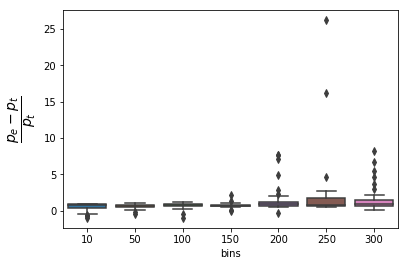

In [117]:
SNSboxPlot(PAE_err5_2, sampleShape,path=getPATH(path, str(mean),"SNSfastPermBox"))

Figure(432x288)


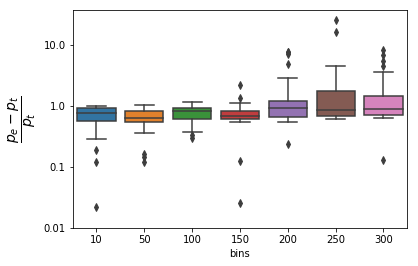

In [120]:
SNSboxPlot(np.log10(np.abs(PAE_err5_2)), sampleShape, 
        path=getPATH(path, str(mean),"SNSfastPermBoxLog"), 
        log=True)

## Parallelization of P-value

Figure(432x288)


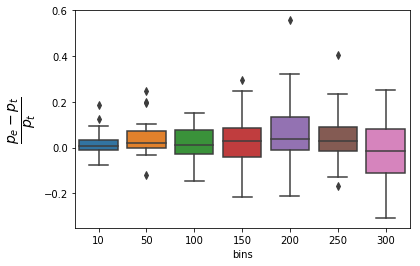

In [121]:
SNSboxPlot(PE_err5_2, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

Figure(432x288)


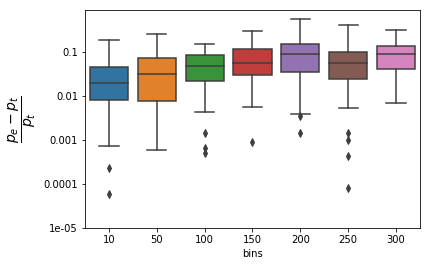

In [122]:
SNSboxPlot(np.log10(np.abs(PE_err5_2)), sampleShape, 
        path=getPATH(path, str(mean),"SNSparallelBoxLog"), 
log=True)

## MannWhitney

Figure(432x288)


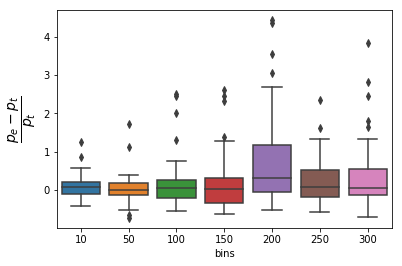

In [123]:
SNSboxPlot(PMW_err5_2, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

Figure(432x288)


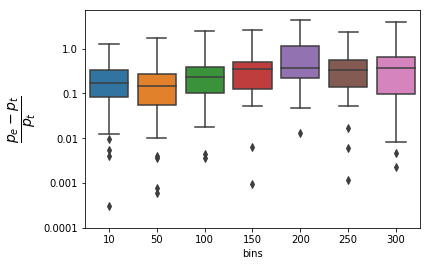

In [124]:
SNSboxPlot(np.log10(np.abs(PMW_err5_2)), sampleShape, 
        path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), 
log=True)

# Experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [125]:
mean = 5.4
X_list5_4, y_list5_4, p_val_list5_4, time_listMc5_4 = loadMcResult(sampleShape, mean)

In [126]:
pe_list5_4, TIME5_4 = shiftMethod(np.asarray(X_list5_4), np.asarray(y_list5_4), 40)


pt_list5_4 = ttest(np.asarray(X_list5_4), np.asarray(y_list5_4))
pmw_list5_4 = mannWhitney(np.asarray(X_list5_4), np.asarray(y_list5_4))
PE_err5_4, PAE_err5_4, PMW_err5_4 = compare(p_val_list5_4, pe_list5_4, pt_list5_4, pmw_list5_4)

## Approximation of P-value

Figure(432x288)


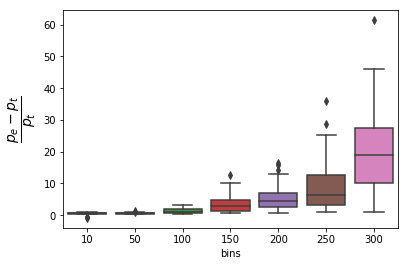

In [127]:
SNSboxPlot(PAE_err5_4, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

Figure(432x288)


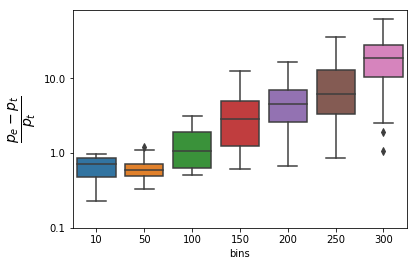

In [128]:
SNSboxPlot(np.log10(np.abs(PAE_err5_4)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True,
       )

## Parallelization of P-value

Figure(432x288)


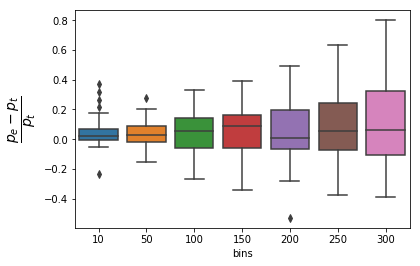

In [129]:
SNSboxPlot(PE_err5_4, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"),
       )

Figure(432x288)


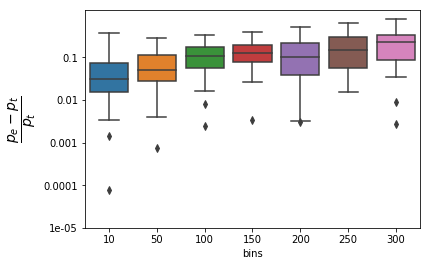

In [130]:
SNSboxPlot(np.log10(np.abs(PE_err5_4)), sampleShape, path=getPATH(path, str(mean),"SNSparallelBoxLog"), log=True,
       )

## MannWhitney

Figure(432x288)


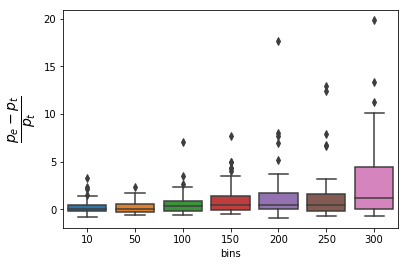

In [131]:
SNSboxPlot(PMW_err5_4, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

Figure(432x288)


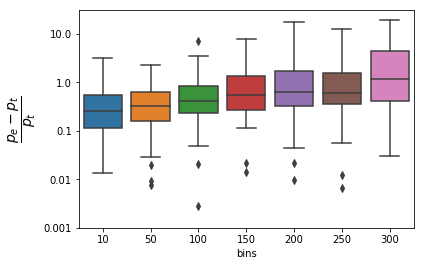

In [132]:
SNSboxPlot(np.log10(np.abs(PMW_err5_4)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

# Experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [133]:
mean=5.6
X_list5_6, y_list5_6, p_val_list5_6, time_listMc5_6 = loadMcResult(sampleShape, mean)

In [134]:
pe_list5_6, TIME5_4 = shiftMethod(np.asarray(X_list5_6), np.asarray(y_list5_6), 40)


pt_list5_6 = ttest(np.asarray(X_list5_6), np.asarray(y_list5_6))
pmw_list5_6 = mannWhitney(np.asarray(X_list5_6), np.asarray(y_list5_6))
PE_err5_6, PAE_err5_6, PMW_err5_6 = compare(p_val_list5_6, pe_list5_6, pt_list5_6, pmw_list5_6)

## Approximation of P-value

Figure(432x288)


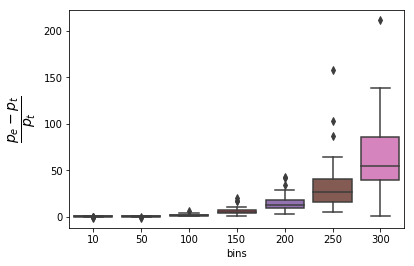

In [135]:
SNSboxPlot(PAE_err5_6, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

Figure(432x288)


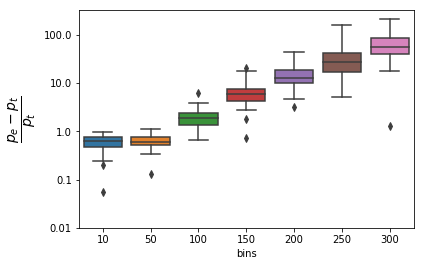

In [136]:
SNSboxPlot(np.log10(np.abs(PAE_err5_6)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True)

## Parallelization of P-value

Figure(432x288)


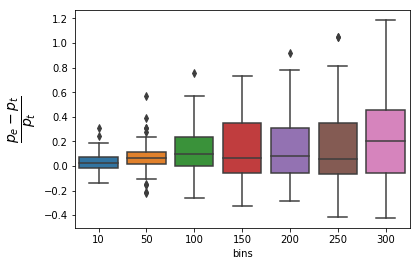

In [137]:
SNSboxPlot(PE_err5_6, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

Figure(432x288)


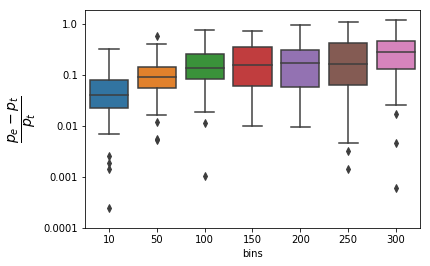

In [138]:
SNSboxPlot(np.log10(np.abs(PE_err5_6)), sampleShape, path=getPATH(path, str(mean),"SNSboxPlot"), log=True)

## MannWhitney

Figure(432x288)


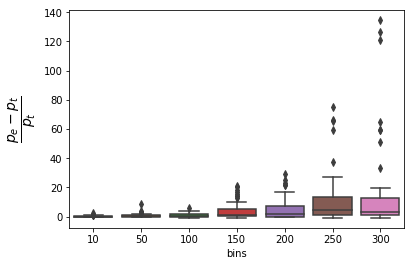

In [139]:
SNSboxPlot(PMW_err5_6, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

Figure(432x288)


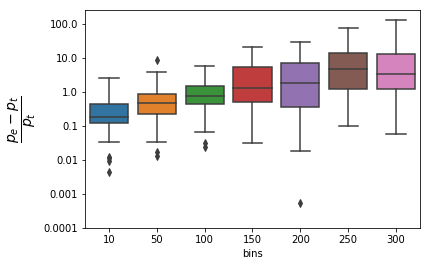

In [140]:
SNSboxPlot(np.log10(np.abs(PMW_err5_6)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

# Experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [141]:
mean=5.8
X_list5_8, y_list5_8, p_val_list5_8, time_listMc5_8 = loadMcResult(sampleShape, mean)

In [142]:
pe_list5_8, TIME5_8 = shiftMethod(np.asarray(X_list5_8), np.asarray(y_list5_8), 40)
pt_list5_8 = ttest(np.asarray(X_list5_8), np.asarray(y_list5_8))
pmw_list5_8 = mannWhitney(np.asarray(X_list5_8), np.asarray(y_list5_8))
PE_err5_8, PAE_err5_8, PMW_err5_8 = compare(p_val_list5_8, pe_list5_8, pt_list5_8, pmw_list5_8)

## Approximation of P-value

Figure(432x288)


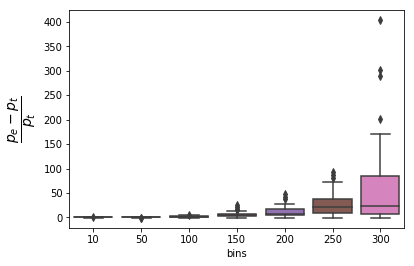

In [143]:
SNSboxPlot(PAE_err5_8, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

Figure(432x288)


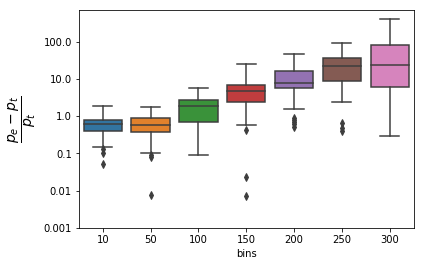

In [144]:
SNSboxPlot(np.log10(np.abs(PAE_err5_8)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True)

## Parallelization of mid P-value

Figure(432x288)


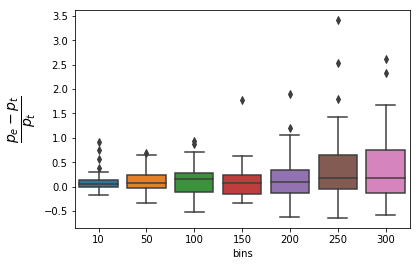

In [145]:
SNSboxPlot(PE_err5_8, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

Figure(432x288)


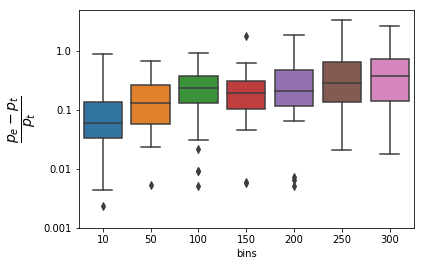

In [146]:
SNSboxPlot(np.log10(np.abs(PE_err5_8)), sampleShape, path=getPATH(path, str(mean),"SNSparallelBoxLog"), log=True)

## MannWhitney

Figure(432x288)


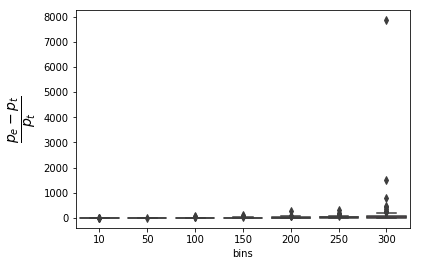

In [147]:
SNSboxPlot(PMW_err5_8, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

Figure(432x288)


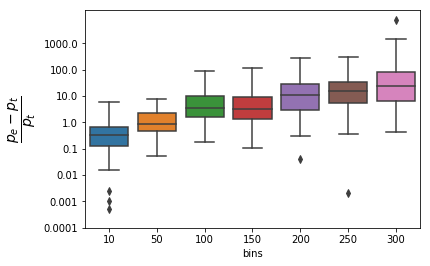

In [148]:
SNSboxPlot(np.log10(np.abs(PMW_err5_8)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

# Experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [149]:
mean=6.0
X_list6_0, y_list6_0, p_val_list6_0, time_listMc6_0 = loadMcResult(sampleShape, int(mean))

In [150]:
pe_list6_0, TIME5_8 = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40)
pt_list6_0 = ttest(np.asarray(X_list6_0), np.asarray(y_list6_0))
pmw_list6_0 = mannWhitney(np.asarray(X_list6_0), np.asarray(y_list6_0))
PE_err6_0, PAE_err6_0, PMW_err6_0 = compare(p_val_list6_0, pe_list6_0, pt_list6_0, pmw_list6_0)

## Approximation of P-value

Figure(432x288)


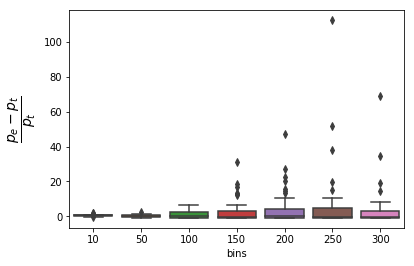

In [151]:
SNSboxPlot(PAE_err6_0, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

Figure(432x288)


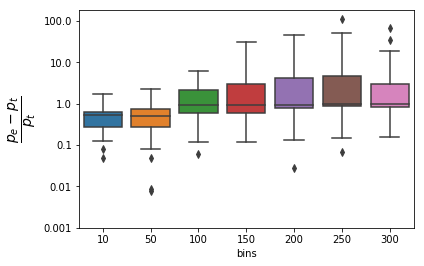

In [152]:
SNSboxPlot(np.log10(np.abs(PAE_err6_0)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True)

## Parallelization of P-value

Figure(432x288)


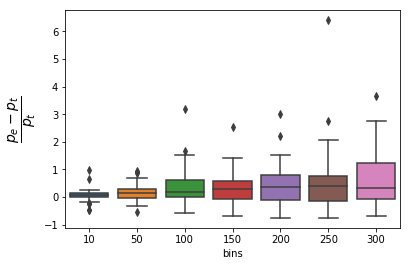

In [153]:
SNSboxPlot(PE_err6_0, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

Figure(432x288)


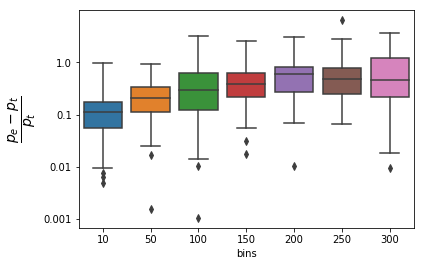

In [154]:
SNSboxPlot(np.log10(np.abs(PE_err6_0)), sampleShape, path=getPATH(path, str(mean),"SNSparallelBoxLog"), log=True)

## MannWhitney

Figure(432x288)


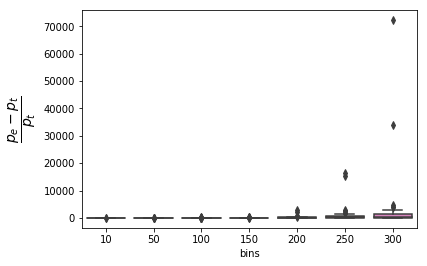

In [155]:
SNSboxPlot(PMW_err6_0, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

Figure(432x288)


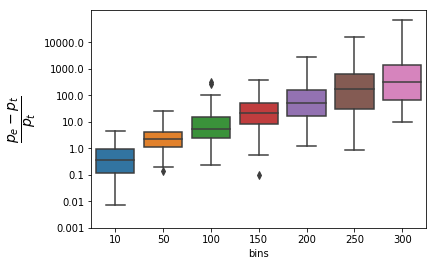

In [156]:
SNSboxPlot(np.log10(np.abs(PMW_err6_0)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

In [157]:
np.log10(np.abs(PMW_err6_0))

array([[-1.09542099e+00, -5.65370703e-01, -4.36575733e-01,
        -9.12643977e-02, -1.95180179e+00, -1.42999557e+00,
         8.67899441e-02,  7.28789273e-02, -3.26581100e-01,
        -1.07341418e+00, -1.69599729e+00, -7.11484419e-01,
        -6.11312709e-01, -2.20705800e-01, -1.07906661e+00,
        -1.42455501e+00, -1.36141352e+00, -2.63287895e-01,
         2.78048618e-01,  2.54017685e-01, -7.38745405e-01,
        -6.65132518e-01, -9.78179114e-01,  6.55846507e-01,
        -3.31664512e-01, -6.72542733e-01,  2.40993174e-01,
        -2.15291844e+00,  1.36439008e-01,  6.96995843e-02,
         1.38854955e-01, -7.02249432e-01, -8.65502017e-01,
         1.63152222e-01, -9.62275536e-01, -2.74693324e-01,
         1.65093219e-01, -7.17299346e-01, -2.89466045e-01,
        -1.92980377e-01, -5.92684360e-01, -1.13038366e+00,
        -2.01335183e+00, -4.81040710e-01,  1.27040520e-03,
        -6.75438313e-01, -6.38887758e-02, -1.25521770e-01,
        -9.33950812e-02,  6.71076056e-01],
       [ 3.70